In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from cluster_util.spark_util import SparkUtil
from cluster_util.hive_util import HiveUtil

In [45]:
spark = SparkUtil().build_spark_session(app_name="Shared Bike Analysis System notebook")

2021-11-22 21:59:01,865	File "spark_util.py", line 25	INFO: Build spark session ...
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/22 21:59:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [47]:
spark.sql('show databases').show()

+----------+
| namespace|
+----------+
|   default|
|sharedbike|
+----------+



In [49]:
spark.sql('use sharedbike')
spark.sql('show tables').show()

+----------+------------+-----------+
| namespace|   tableName|isTemporary|
+----------+------------+-----------+
|sharedbike|trip_details|      false|
+----------+------------+-----------+



In [51]:
ptd="2021"
desc_list_names = ['duration', 'start_lat', 'start_lon', 'end_lat', 'end_lon', 'plan_duration',  'trip_route_type',
                               'passholder_type', 'bike_type', 'distance', 'season', 'holiday', 'workingday']
df_by_year = spark.sql('select {} from trip_details where ptd={};'.format(','.join(desc_list_names), ptd))

In [54]:
df_by_year.toPandas().describe().T

,count,mean,std,min,25%,50%,75%,max
duration,153989.0,41.147673,98.049854,1.000000,9.000000,19.000000,37.000000,1440.000000
start_lat,153989.0,34.029836,0.038370,33.928459,33.996239,34.038609,34.050880,34.186569
start_lon,153989.0,-118.345096,0.096136,-118.491341,-118.451248,-118.291496,-118.258537,-118.225410
end_lat,153989.0,34.029810,0.038001,33.928459,33.998341,34.037460,34.050480,34.186569
end_lon,153989.0,-118.345834,0.096722,-118.491341,-118.451248,-118.291718,-118.258537,-118.225410
plan_duration,153989.0,48.578457,102.870918,1.000000,1.000000,30.000000,30.000000,999.000000
trip_route_type,153989.0,1.243537,0.429218,1.000000,1.000000,1.000000,1.000000,2.000000
passholder_type,153988.0,2.317849,1.024294,1.000000,1.000000,3.000000,3.000000,4.000000
bike_type,153989.0,1.278773,0.471785,1.000000,1.000000,1.000000,2.000000,3.000000
distance,153989.0,29.592958,35.449078,0.000000,4.025301,20.554560,41.013824,517.316467


In [55]:
spark.stop()

In [56]:
trip_data_by_year = pd.read_csv('results/trip_details/part-00000-d8beedf0-5cb4-410f-b3f3-8e53fd00d04c-c000.csv')

In [57]:
trip_data_by_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153989 entries, 0 to 153988
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   trip_id          153989 non-null  int64  
 1   duration         153989 non-null  int64  
 2   start_station    153989 non-null  int64  
 3   start_lat        153989 non-null  float64
 4   start_lon        153989 non-null  float64
 5   end_station      153989 non-null  int64  
 6   end_lat          153989 non-null  float64
 7   end_lon          153989 non-null  float64
 8   bike_id          153981 non-null  float64
 9   plan_duration    153989 non-null  int64  
 10  trip_route_type  153989 non-null  int64  
 11  passholder_type  153988 non-null  float64
 12  bike_type        153989 non-null  int64  
 13  distance         153989 non-null  float64
 14  distance_cal     153989 non-null  float64
 15  used_date        153989 non-null  object 
 16  season           153989 non-null  int6

In [58]:
trip_data_by_year[['duration', 'start_lat', 'start_lon', 'end_lat', 'end_lon', 'plan_duration',  'trip_route_type',
                               'passholder_type', 'bike_type', 'distance', 'season', 'holiday', 'workingday']].describe().T

,count,mean,std,min,25%,50%,75%,max
duration,153989.0,41.147673,98.049854,1.000000,9.000000,19.000000,37.000000,1440.000000
start_lat,153989.0,34.029836,0.038370,33.928459,33.996239,34.038609,34.050880,34.186569
start_lon,153989.0,-118.345096,0.096136,-118.491341,-118.451248,-118.291496,-118.258537,-118.225410
end_lat,153989.0,34.029810,0.038001,33.928459,33.998341,34.037460,34.050480,34.186569
end_lon,153989.0,-118.345834,0.096722,-118.491341,-118.451248,-118.291718,-118.258537,-118.225410
plan_duration,153989.0,48.578457,102.870918,1.000000,1.000000,30.000000,30.000000,999.000000
trip_route_type,153989.0,1.243537,0.429218,1.000000,1.000000,1.000000,1.000000,2.000000
passholder_type,153988.0,2.317849,1.024294,1.000000,1.000000,3.000000,3.000000,4.000000
bike_type,153989.0,1.278773,0.471785,1.000000,1.000000,1.000000,2.000000,3.000000
distance,153989.0,29.592954,35.449079,0.000000,4.025301,20.554560,41.013824,517.316470


<AxesSubplot:xlabel='workingday', ylabel='count'>

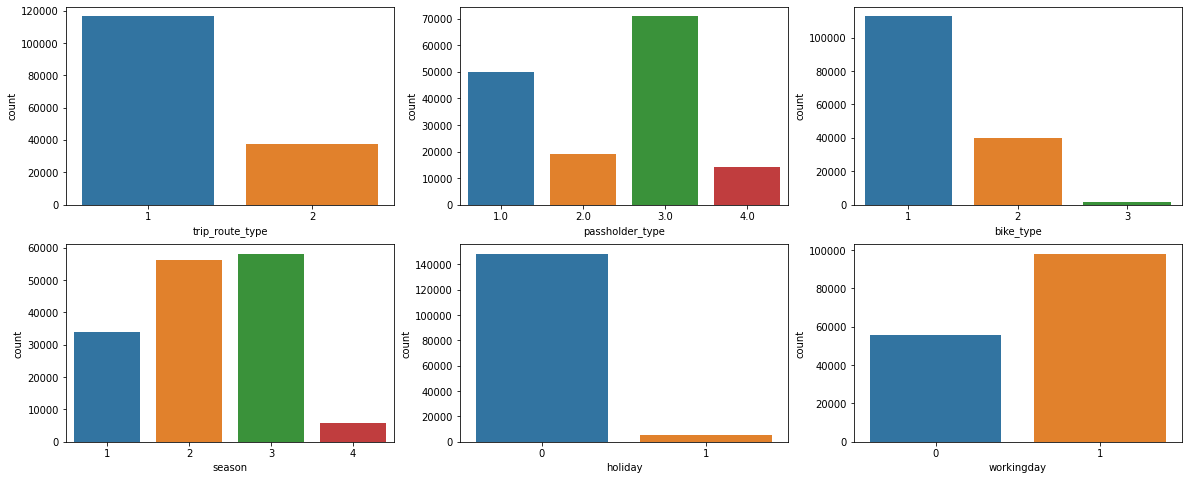

In [61]:
# countplot in categorical variable
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(20, 8)

# col_name = ['trip_route_type', 'passholder_type', 'bike_type', 'season', 'holiday', 'workingday']

sns.countplot(trip_data_by_year['trip_route_type'], ax=axes[0][0])
sns.countplot(trip_data_by_year['passholder_type'], ax=axes[0][1])
sns.countplot(trip_data_by_year['bike_type'], ax=axes[0][2])
sns.countplot(trip_data_by_year['season'], ax=axes[1][0])
sns.countplot(trip_data_by_year['holiday'], ax=axes[1][1])
sns.countplot(trip_data_by_year['workingday'], ax=axes[1][2])

<AxesSubplot:xlabel='season'>

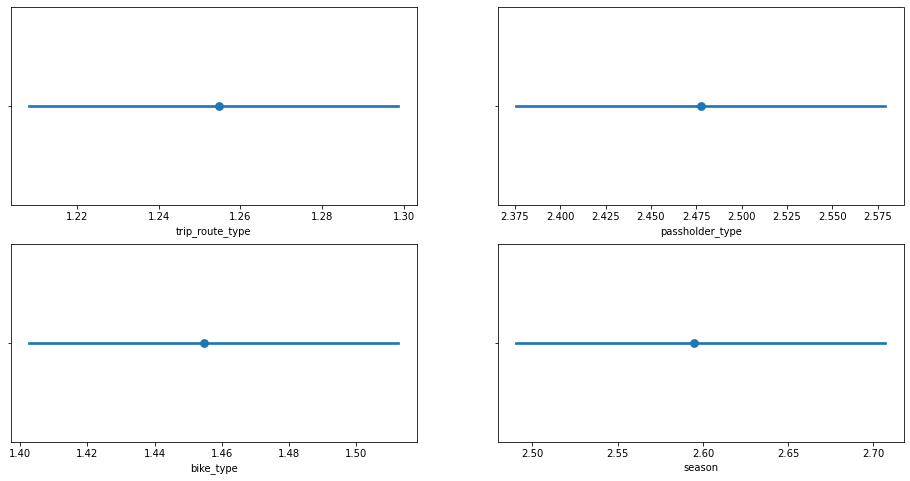

In [36]:
# pointplot in categorical variable
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(16,8)


sns.pointplot(data=trip_data_by_year, x='trip_route_type', ax=axes[0][0])
sns.pointplot(data=trip_data_by_year, x='passholder_type', ax=axes[0][1])
sns.pointplot(data=trip_data_by_year, x='bike_type', ax=axes[1][0])
sns.pointplot(data=trip_data_by_year, x='season', ax=axes[1][1])

# sns.pointplot(data=trip_data_by_year, x='trip_route_type', ax=axes[0][0])
# sns.pointplot(data=trip_data_by_year, x='passholder_type', ax=axes[0][1])
# sns.pointplot(data=trip_data_by_year, x='bike_type', ax=axes[0][2])
# sns.pointplot(data=trip_data_by_year, x='season', ax=axes[1][0])
# sns.pointplot(data=trip_data_by_year, x='holiday', ax=axes[1][1])
# sns.pointplot(data=trip_data_by_year, x='workingday', ax=axes[1][2])